In [1]:
import librosa
import numpy as np

def extract_features(file_name):
    try:
        y, sr = librosa.load(file_name, res_type='kaiser_fast') 
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60)
        mfccScaled = np.mean(mfcc.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccScaled

In [2]:
# Load various imports 
import pandas as pd
import os
import librosa
from datetime import datetime 

# Set the path to the full UrbanSound dataset 
# 여기는 각자 경로에 맞게
generalSoundPath = 'Audio-Classification/General-Sounds/'
legalVoicePath = 'Audio-Classification/User-Voices/Legal-Voices/'
illegalVoicePath = 'Audio-Classification/User-Voices/Illegal-Voices/'

def fetchDataset(path, class_label):
    features = []
    filename_list = []
    for dirpath, dirnames, filenames in os.walk(path):
        print(dirpath)
        filename_list = filename_list + filenames
        for filename in filenames:
            file_name = os.path.join(dirpath, filename)
            data = extract_features(file_name)
            features.append([data, class_label])
    return features, filename_list
            
start = datetime.now()

gs, gs_name = fetchDataset(generalSoundPath, 'General Sound')
lv, lv_name = fetchDataset(legalVoicePath, 'Legal Voice')
iv, iv_name = fetchDataset(illegalVoicePath, 'Illegal Voice')
features = gs + lv + iv

duration = datetime.now() - start
print(duration)

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from', len(featuresdf), 'files')

Audio-Classification/General-Sounds/
Audio-Classification/General-Sounds/Animal-Sounds
Audio-Classification/General-Sounds/Natural-Sounds
Audio-Classification/General-Sounds/Other-Sounds
Audio-Classification/General-Sounds/Things-Sounds
Audio-Classification/User-Voices/Legal-Voices/
Audio-Classification/User-Voices/Legal-Voices/Movie-Voices
Audio-Classification/User-Voices/Legal-Voices/Music-Voices
Audio-Classification/User-Voices/Legal-Voices/Other-Voices
Audio-Classification/User-Voices/Legal-Voices/TV-Voices
Audio-Classification/User-Voices/Legal-Voices/YouTube-Voices
Audio-Classification/User-Voices/Illegal-Voices/
Audio-Classification/User-Voices/Illegal-Voices/Telephone-Recorded
Audio-Classification/User-Voices/Illegal-Voices/User-Agreed
Audio-Classification/User-Voices/Illegal-Voices/User-Not-Agreed
0:18:06.033753
Finished feature extraction from 10012 files


In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [4]:
# split the dataset 
from sklearn.model_selection import train_test_split 
from collections import Counter

x_temp, x_test, y_temp, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state = 42)

print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_val, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({2: 2537, 0: 1736, 1: 1733})
Counter({2: 864, 1: 572, 0: 567})
Counter({2: 845, 1: 585, 0: 573})


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation#, Flatten

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=x_train[0].shape))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(yy.shape[1]))
model.add(Activation('softmax'))

In [6]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [7]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               15616     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [8]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
188/188 [==============================] - 2s 3ms/step - loss: 6.8705 - accuracy: 0.4837 - val_loss: 0.7311 - val_accuracy: 0.6785

Epoch 00001: val_loss improved from inf to 0.73113, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 1.2087 - accuracy: 0.5861 - val_loss: 0.7973 - val_accuracy: 0.7559

Epoch 00002: val_loss did not improve from 0.73113
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 0.8294 - accuracy: 0.6565 - val_loss: 0.6651 - val_accuracy: 0.7923

Epoch 00003: val_loss improved from 0.73113 to 0.66514, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 0.6957 - accuracy: 0.7080 - val_loss: 0.5993 - val_accuracy: 0.8078

Epoch 00004: val_loss improved from 0.66514 to 0.59927, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 5/100
188/188 [=================

188/188 [==============================] - 1s 3ms/step - loss: 0.2228 - accuracy: 0.9154 - val_loss: 0.2155 - val_accuracy: 0.9191

Epoch 00035: val_loss did not improve from 0.19975
Epoch 36/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2079 - accuracy: 0.9182 - val_loss: 0.2025 - val_accuracy: 0.9221

Epoch 00036: val_loss did not improve from 0.19975
Epoch 37/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2173 - accuracy: 0.9163 - val_loss: 0.1915 - val_accuracy: 0.9286

Epoch 00037: val_loss improved from 0.19975 to 0.19146, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 38/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2097 - accuracy: 0.9207 - val_loss: 0.2087 - val_accuracy: 0.9276

Epoch 00038: val_loss did not improve from 0.19146
Epoch 39/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2085 - accuracy: 0.9207 - val_loss: 0.1993 - val_accuracy: 0.9236

Epoch 00039: val_loss 

188/188 [==============================] - 1s 3ms/step - loss: 0.1591 - accuracy: 0.9432 - val_loss: 0.1888 - val_accuracy: 0.9361

Epoch 00075: val_loss did not improve from 0.16610
Epoch 76/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1441 - accuracy: 0.9484 - val_loss: 0.1787 - val_accuracy: 0.9401

Epoch 00076: val_loss did not improve from 0.16610
Epoch 77/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1688 - accuracy: 0.9437 - val_loss: 0.1798 - val_accuracy: 0.9421

Epoch 00077: val_loss did not improve from 0.16610
Epoch 78/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1540 - accuracy: 0.9486 - val_loss: 0.1789 - val_accuracy: 0.9376

Epoch 00078: val_loss did not improve from 0.16610
Epoch 79/100
188/188 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.94 - ETA: 0s - loss: 0.1464 - accuracy: 0.94 - 1s 3ms/step - loss: 0.1464 - accuracy: 0.9476 - val_loss: 0.1806 - val_accuracy: 0.9446



In [9]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9766899943351746
Validation Accuracy:  0.9380928874015808
Testing Accuracy:  0.9340988397598267


['General Sound' 'Illegal Voice' 'Legal Voice']


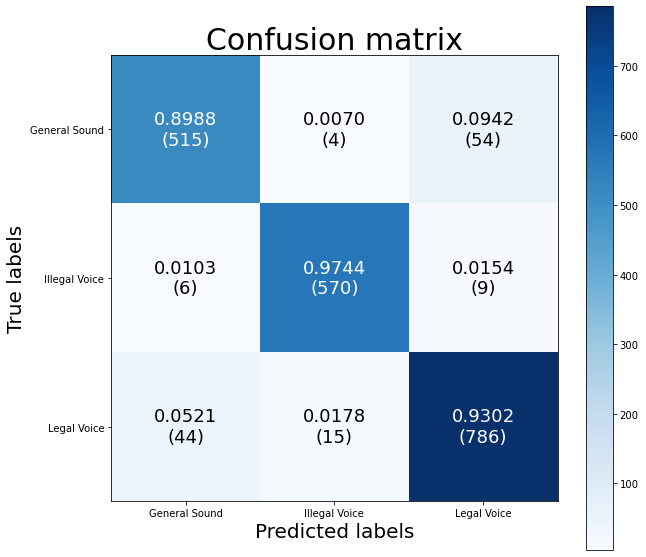

               precision    recall  f1-score   support

General Sound       0.91      0.90      0.91       573
Illegal Voice       0.97      0.97      0.97       585
  Legal Voice       0.93      0.93      0.93       845

     accuracy                           0.93      2003
    macro avg       0.94      0.93      0.93      2003
 weighted avg       0.93      0.93      0.93      2003



In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from matplotlib.colors import Normalize

def plotConfusionMat(true, pred, labelEncoder):
    confusion_mat = confusion_matrix(true, pred)
    ratio_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    
    plt.rcParams["figure.figsize"] = (10, 10)
    
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', fontsize=30)
    plt.xlabel('Predicted labels', fontsize=20)
    plt.ylabel('True labels', fontsize=20)
    
    ticks = np.arange(len(labelEncoder.classes_))
    plt.xticks(ticks, labelEncoder.classes_)
    plt.yticks(ticks, labelEncoder.classes_)
    plt.colorbar()
    
    thresh = confusion_mat.max() / 2
    for i in range(len(labelEncoder.classes_)):
        for j in range(len(labelEncoder.classes_)):
            plt.text(j, i, "{:0.4f}\n({})".format(ratio_mat[i, j], confusion_mat[i, j]),
                     ha="center", va="center",
                     color="white" if confusion_mat[i, j] > thresh else "black",
                     fontsize=18)
    
    plt.show()

    
print(le.classes_)

y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
plotConfusionMat(y_true, y_pred, le)

print(classification_report(y_true, y_pred, target_names=le.classes_))

In [11]:
def print_prediction(file_name):
    prediction_feature = np.expand_dims(extract_features(file_name), axis=0)
    predicted_proba_vector = model.predict(prediction_feature)
    
    predicted_class_vector = np.argmax(predicted_proba_vector, axis=-1)
    predicted_class = le.inverse_transform(predicted_class_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        print(le.classes_[i], "\t\t : ", format(predicted_proba[i], '.32f') )

In [22]:
from IPython.display import Audio 
from IPython.core.display import display

# Legal
filename = 'V-YT-PSY-006051.wav'
# filename = 'Audio-Classification/Music-Sounds/G-MS-HYI-000028.wav'

display(Audio(filename, autoplay=True))
print_prediction(filename)

The predicted class is: Legal Voice 

General Sound 		 :  0.06350473314523696899414062500000
Illegal Voice 		 :  0.05252375826239585876464843750000
Legal Voice 		 :  0.88397145271301269531250000000000


In [13]:
gsDf = pd.DataFrame(gs, columns=['feature','class_label'])
lvDf = pd.DataFrame(lv, columns=['feature','class_label'])
ivDf = pd.DataFrame(iv, columns=['feature','class_label'])

gs_x = np.array(gsDf.feature.tolist())
lv_x = np.array(lvDf.feature.tolist())
iv_x = np.array(ivDf.feature.tolist())

In [14]:
gs_predicted = np.argmax(model.predict(gs_x), axis=-1)
lv_predicted = np.argmax(model.predict(lv_x), axis=-1)
iv_predicted = np.argmax(model.predict(iv_x), axis=-1)

print('General Sound')
for i, c in enumerate(gs_predicted):
    if c != 0:
        print(c, gs_name[i])
        
print('Legal Voice')
for i, c in enumerate(lv_predicted):
    if c != 2:
        print(c, lv_name[i])
        
print('Illegal Voice')
for i, c in enumerate(iv_predicted):
    if c != 1:
        print(c, iv_name[i])

General Sound
2 G-AS-HYL-000024.wav
2 G-AS-HYL-000047.wav
1 G-AS-HYL-000096.wav
2 G-AS-HYL-000101.wav
1 G-AS-HYL-000135.wav
1 G-AS-HYL-000161.wav
2 G-AS-HYL-000185.wav
2 G-AS-HYL-000194.wav
2 G-AS-HYL-000197.wav
2 G-AS-HYL-000198.wav
2 G-AS-HYL-000212.wav
1 G-AS-HYL-000216.wav
1 G-AS-HYL-000234.wav
2 G-AS-HYL-000239.wav
1 G-AS-HYL-000264.wav
2 G-AS-HYL-000281.wav
2 G-AS-HYL-000288.wav
2 G-AS-HYL-000318.wav
2 G-AS-HYL-000319.wav
2 G-AS-HYL-000335.wav
2 G-AS-HYL-000343.wav
2 G-AS-HYL-000349.wav
2 G-AS-HYL-000352.wav
2 G-AS-HYL-000361.wav
2 G-AS-HYL-000373.wav
2 G-AS-HYL-000374.wav
2 G-AS-HYL-000379.wav
2 G-AS-HYL-000388.wav
2 G-AS-HYL-000389.wav
2 G-AS-HYL-000392.wav
2 G-AS-HYL-000457.wav
2 G-AS-HYL-000459.wav
2 G-AS-HYL-000465.wav
2 G-AS-HYU-000243.wav
2 G-AS-HYU-000254.wav
2 G-AS-HYU-000255.wav
2 G-AS-HYU-000256.wav
2 G-AS-HYU-000261.wav
1 G-AS-HYU-000336.wav
2 G-AS-HYU-000352.wav
2 G-AS-HYU-000375.wav
2 G-AS-HYU-000407.wav
2 G-AS-HYU-000411.wav
2 G-AS-HYU-000426.wav
2 G-AS-HYU-000472.

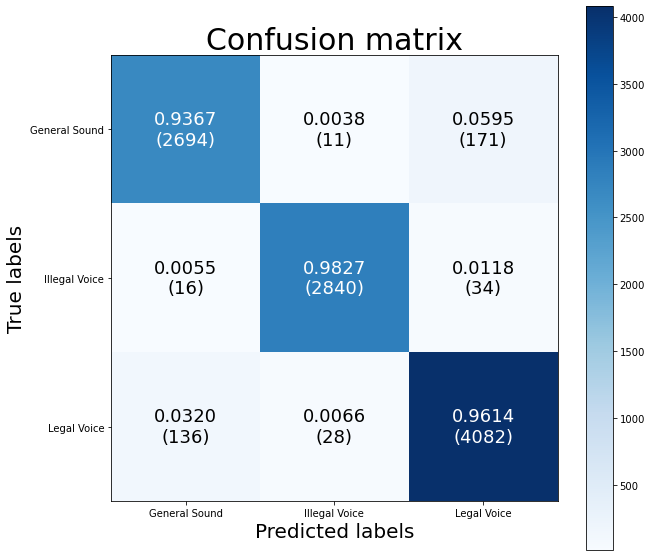

               precision    recall  f1-score   support

General Sound       0.95      0.94      0.94      2876
Illegal Voice       0.99      0.98      0.98      2890
  Legal Voice       0.95      0.96      0.96      4246

     accuracy                           0.96     10012
    macro avg       0.96      0.96      0.96     10012
 weighted avg       0.96      0.96      0.96     10012



In [15]:
y_pred = np.argmax(model.predict(X), axis=-1)
y_true = le.fit_transform(y)

plotConfusionMat(y_true, y_pred, le)

print(classification_report(y_true, y_pred, target_names=le.classes_))

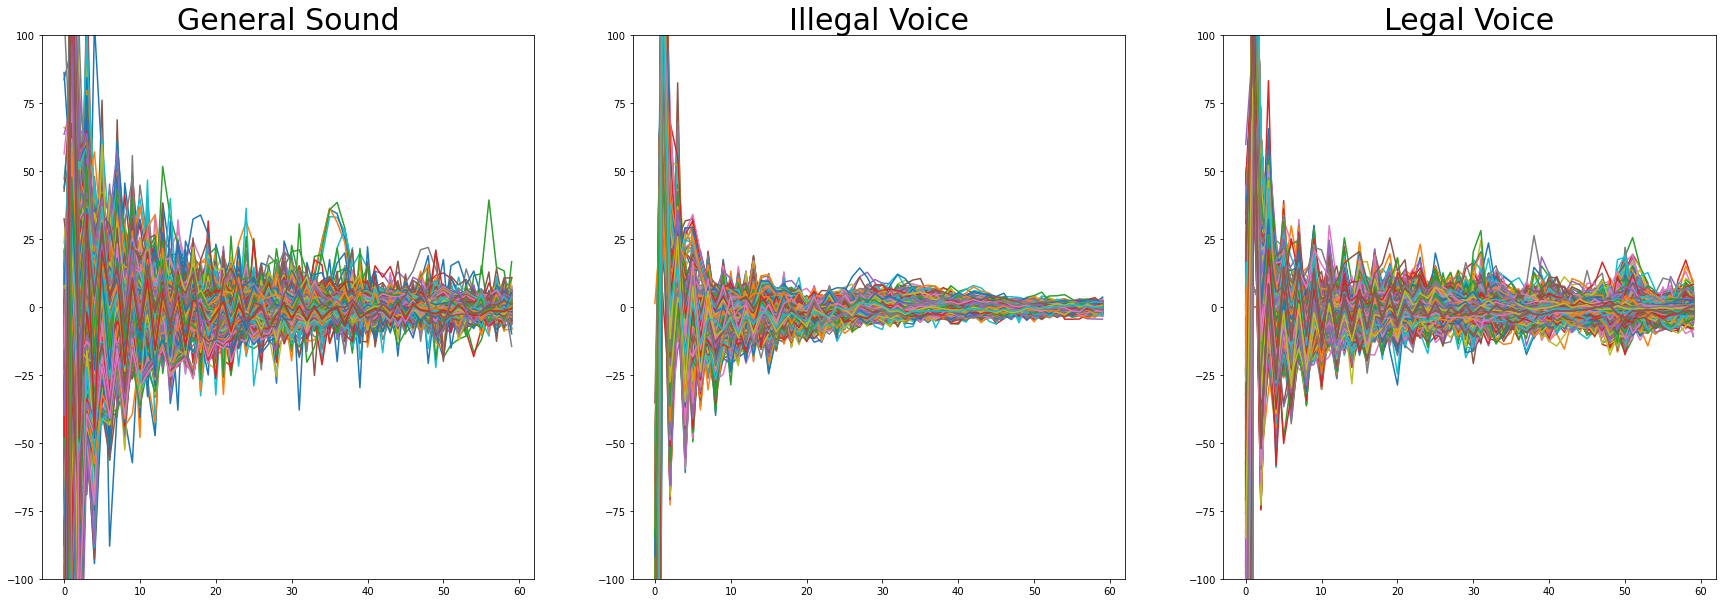

In [16]:
x_values = np.arange(60)

plt.rcParams["figure.figsize"] = (30, 10)

plt.subplot(1, 3, 1)
plt.title('General Sound', fontsize=30)
plt.ylim([-100, 100])
for x in gs:
    plt.plot(x_values, x[0])
    
plt.subplot(1, 3, 2)
plt.title('Illegal Voice', fontsize=30)
plt.ylim([-100, 100])
for x in iv:
    plt.plot(x_values, x[0])
    
plt.subplot(1, 3, 3)
plt.title('Legal Voice', fontsize=30)
plt.ylim([-100, 100])
for x in lv:
    plt.plot(x_values, x[0])

plt.show()